В данном задании вам предстоит помочь [The Nature Conservancy](https://www.nature.org/en-us/about-us/where-we-work/united-states/california/) в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
(https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb). Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на [Leaderboard](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/leaderboard).

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

Using plaidml.keras.backend backend.


In [ ]:
import warnings
warnings.simplefilter(action='ignore')

#Загрузка и подоговка данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.utils import np_utils
import json

In [ ]:
import wget

In [ ]:
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5458/bet_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5459/shark_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5460/dol_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5461/yft_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5462/alb_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5463/lag_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147332/5471/other_labels.json')
# wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/158691/5864/NoF_labels.json')

In [ ]:
trn_images = []
trn_labels = []

for category in os.listdir("train/"):
    if os.path.isdir("train/%s" % (category)):
        for img in os.listdir("train/%s" % (category)):
            if img.endswith(".jpg"):
                trn_images.append("train/%s/%s" % (category, img))
                trn_labels.append("%s" % (category))

In [ ]:
trn_images[:5]

['train/ALB/img_00003.jpg',
 'train/ALB/img_00010.jpg',
 'train/ALB/img_00012.jpg',
 'train/ALB/img_00015.jpg',
 'train/ALB/img_00019.jpg']

In [ ]:
trn_labels[:5]

['ALB', 'ALB', 'ALB', 'ALB', 'ALB']

Распределение данных по классам

In [ ]:
dataset = pd.DataFrame({"images": trn_images, "labels": trn_labels})

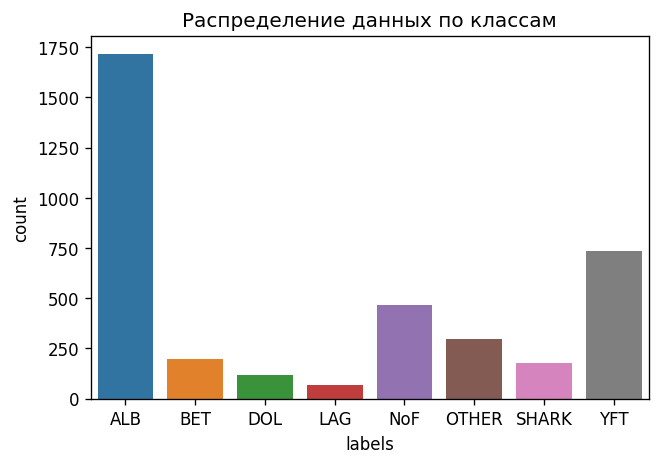

In [ ]:
plt.figure(figsize=(6, 4), dpi=120)
sns.countplot(dataset.labels)
plt.title('Распределение данных по классам')
plt.show()

In [ ]:
grouped = dataset.groupby("labels")

In [ ]:
filenames = [img[0] for img in grouped.first().values]
labels = [filename.split("/")[1] for filename in filenames]

In [ ]:
x = []
y = []
for filename, label in zip(filenames, labels):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    x.append(img)
    y.append(label)

Визуализация нескольких изображений

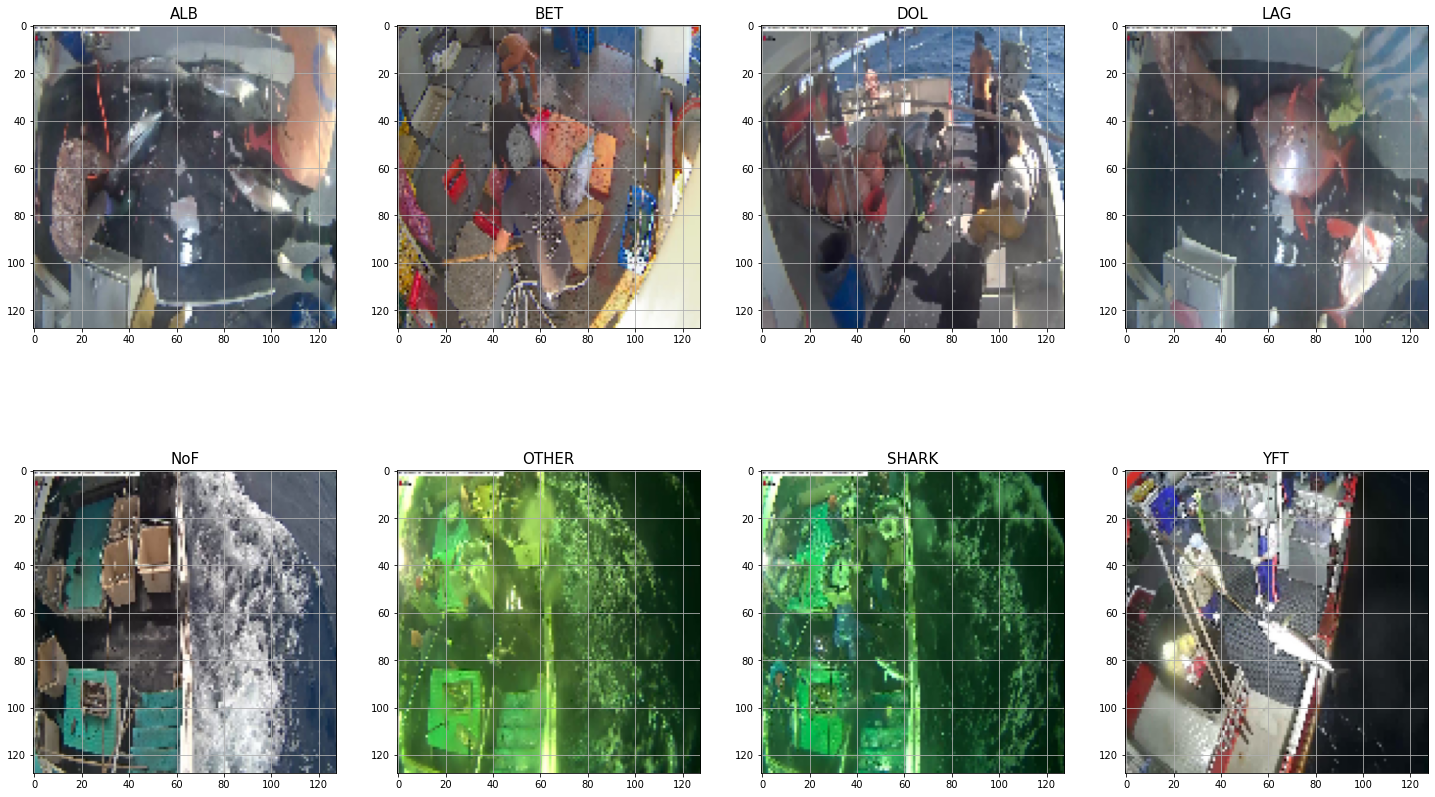

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(25, 15))
for ax, img, label in zip(axs.flatten(), x, y):
    ax.set_title(label, fontsize=15)
    ax.imshow(img)
    ax.grid(True)

plt.show()

In [ ]:
label2idx = {k:i for i, k in enumerate(labels)}
idx2label = {i:k for i, k in enumerate(labels)}

In [ ]:
X_train = np.zeros((3777, 128, 128, 3))
y_train = []
trn_size = np.zeros((3777, 2))
trn_filename = np.empty(3777, dtype=np.object)

In [ ]:
print(X_train.shape, len(y_train), trn_size.shape, trn_filename.shape)

(3777, 128, 128, 3) 0 (3777, 2) (3777,)


In [ ]:
counter = 0
for rec in dataset.values:
    img = cv2.imread(rec[0])
    height, width, channel = img.shape
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    X_train[counter] = img
    y_train.append(label2idx.get(rec[1]))
    trn_size[counter][0] = width
    trn_size[counter][1] = height
    trn_filename[counter] = rec[0].split('/')[2]

    counter += 1

In [ ]:
y_train = keras.utils.to_categorical(y_train, 8)
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]
trn_size = trn_size[permutation]
trn_filename = trn_filename[permutation]

In [ ]:
y_train[100:102]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(trn_size[0:5])
print(trn_filename[0:5])

(3777, 128, 128, 3)
(3777, 8)
[[1280.  974.]
 [1280.  720.]
 [1280.  750.]
 [1280.  720.]
 [1276.  718.]]
['img_01190.jpg' 'img_00636.jpg' 'img_04627.jpg' 'img_00379.jpg'
 'img_03972.jpg']


In [ ]:
anno_classes = ['alb', 'bet', 'dol', 'lag','nof', 'other', 'shark', 'yft']

In [ ]:
bb_json = {}

for c in anno_classes:
    j = json.load(open('{}_labels.json'.format(c), 'r'))

    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb_json[l['filename']] = l['annotations'][-1]

In [ ]:
bb_json['img_07763.jpg']

{'class': 'rect',
 'height': 127.00000000000045,
 'width': 121.00000000000045,
 'x': 636.0000000000023,
 'y': 353.00000000000125}

In [ ]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [ ]:
for f in trn_filename:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [ ]:
bb_json['img_07763.jpg']

{'class': 'rect',
 'height': 127.00000000000045,
 'width': 121.00000000000045,
 'x': 636.0000000000023,
 'y': 353.00000000000125}

In [ ]:
def convert_bb(img, width, height):
    bb = []
    conv_x = (224. / width)
    conv_y = (224. / height)
    bb.append(bb_json[img]['height'] * conv_y)
    bb.append(bb_json[img]['width'] * conv_x)
    bb.append(max(bb_json[img]['x'] * conv_x, 0))
    bb.append(max(bb_json[img]['y'] * conv_y, 0))
    return bb

In [ ]:
trn_resize_dim = []
trn_bbox = []

In [ ]:
for i in range(len(trn_filename)):
    trn_bbox.append(convert_bb(trn_filename[i], trn_size[i][0], trn_size[i][1]))

In [ ]:
trn_bbox = np.asarray(trn_bbox)

In [ ]:
print(trn_bbox[100])

[101.91104  28.1295  186.29625  86.3296 ]


In [ ]:
print(trn_filename[100])

img_01203.jpg


In [ ]:
bb_json.get('img_03693.jpg')

{'class': 'rect',
 'height': 198.30151285353523,
 'width': 246.98631541039117,
 'x': 453.5998677248531,
 'y': 218.48789440149991}

#Обучение модели

**Для обучения и классификации будем использовать нероросеть ResNet50**

ResNet50 (Residual Network 50) - это глубокая сверточная нейронная сеть, представленная в 2015 году в статье "Deep Residual Learning for Image Recognition" командой Microsoft Research. Эта модель является одной из наиболее известных архитектур глубокого обучения и применяется для классификации изображений, обнаружения объектов и других задач компьютерного зрения.

Особенности модели ResNet50:

1. Глубокая архитектура: ResNet50 имеет глубокую архитектуру, состоящую из 50 слоев свертки и объединения. Это позволяет сети выучивать сложные и абстрактные признаки из изображений.

2. Остаточные блоки (Residual Blocks): Основной идеей ResNet50 являются остаточные блоки, которые предназначены для решения проблемы затухающего градиента при обучении глубоких нейронных сетей. Вместо того чтобы пытаться научить сеть выучивать функцию F(x), остаточные блоки вычисляют "остаточную" функцию F(x) - x, что позволяет переопределить градиенты и упростить обучение.

3. Пропуск соединений (Shortcut Connections): Остаточные блоки имеют "пропуск соединения", который добавляет входные данные (x) к выходным данным (F(x)) слоя. Это делает обучение более стабильным и позволяет глубоким сетям успешно обучаться без значительного ухудшения точности.

4. Свертки 1x1: В ResNet50 применяются свертки 1x1 для сокращения размерности и уменьшения числа параметров в сети. Свертки 1x1 выполняют линейные комбинации признаков и помогают уменьшить вычислительную сложность модели.

5. Свертки 3x3 и 5x5: ResNet50 также использует свертки 3x3 и 5x5 для извлечения признаков из изображений разных масштабов.

Принцип работы ResNet50:

Процесс работы ResNet50 основан на передаче информации через остаточные блоки с пропусками соединений. Когда данные проходят через каждый остаточный блок, они могут пройти два пути: через сверточные слои и через пропуск соединение, где добавляются к исходным данным. Это позволяет передавать информацию и градиенты без затухания и предотвращает возникновение проблемы градиентного затухания при обучении глубоких сетей.

Когда модель ResNet50 обучается, веса сверточных слоев и остаточных блоков настраиваются таким образом, чтобы минимизировать ошибку классификации на обучающих данных. После обучения модель может быть использована для классификации изображений или других задач компьютерного зрения, предсказывая принадлежность изображения к различным классам или детектируя объекты на изображении.

Благодаря применению остаточных блоков и пропускам соединений, ResNet50 стала одной из наиболее эффективных архитектур глубокого обучения, способной обучаться глубоким моделям с высокой точностью и стабильностью.



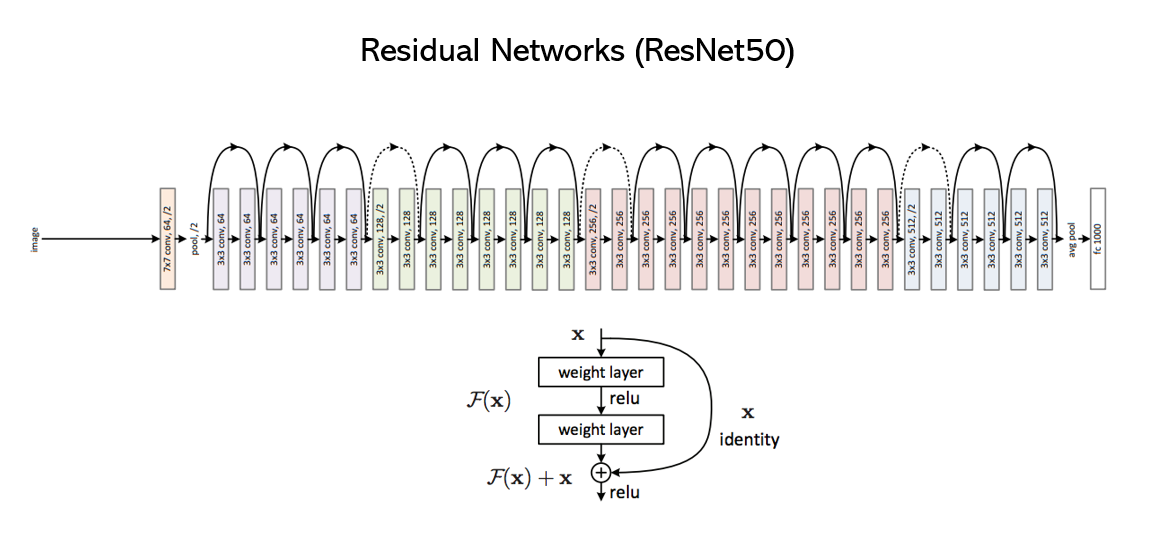

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications import ResNet50
from keras.optimizers import Adam

In [ ]:
base_model_resnet50 = ResNet50(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

INFO:plaidml:Opening device "opencl_amd_iceland.0"


In [ ]:
for layer in base_model_resnet50.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model_resnet50.output)
x = Dense(512, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)

x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [ ]:
model_resnet50 = Model(base_model_resnet50.input, [x_bb, x_class])

In [ ]:
model_resnet50.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
model_resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Total params: 40,634,252
Trainable params: 17,046,540
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [ ]:
model_resnet50.fit(X_train, [trn_bbox, y_train], batch_size=64, epochs=10, validation_split=0.1)

Train on 3399 samples, validate on 378 samples
Epoch 1/10


INFO:plaidml:Analyzing Ops: 389 of 1417 operations complete
INFO:plaidml:Analyzing Ops: 1126 of 1417 operations complete


3392/3399 [============================>.] - ETA: 0s - loss: 1120.2013 - bb_loss: 1116.8258 - class_loss: 3.3755 - bb_acc: 0.6536 - class_acc: 0.4873

INFO:plaidml:Analyzing Ops: 593 of 1417 operations complete


3399/3399 [==============================] - 174s 51ms/step - loss: 1120.9909 - bb_loss: 1117.6211 - class_loss: 3.3699 - bb_acc: 0.6537 - class_acc: 0.4881 - val_loss: 2179.1020 - val_bb_loss: 2175.1229 - val_class_loss: 3.9791 - val_bb_acc: 0.6958 - val_class_acc: 0.4550
Epoch 2/10
3399/3399 [==============================] - 86s 25ms/step - loss: 434.6666 - bb_loss: 433.7165 - class_loss: 0.9500 - bb_acc: 0.6690 - class_acc: 0.7570 - val_loss: 2024.4187 - val_bb_loss: 2020.9811 - val_class_loss: 3.4377 - val_bb_acc: 0.6746 - val_class_acc: 0.4577
Epoch 3/10
3399/3399 [==============================] - 85s 25ms/step - loss: 287.6025 - bb_loss: 286.9796 - class_loss: 0.6229 - bb_acc: 0.6764 - class_acc: 0.8261 - val_loss: 1819.3566 - val_bb_loss: 1816.2087 - val_class_loss: 3.1479 - val_bb_acc: 0.6508 - val_class_acc: 0.5556
Epoch 4/10
3399/3399 [==============================] - 85s 25ms/step - loss: 208.6021 - bb_loss: 208.1258 - class_loss: 0.4763 - bb_acc: 0.6846 - class_acc: 0.85

In [ ]:
model_resnet50.save('model_resnet50_fish.h5')

In [ ]:
path  = 'test_stg2'
file_names = [os.path.join(path, f)
                      for f in os.listdir(path)
                      if f.endswith(".jpg")]
images = []
for f in file_names:
    img = cv2.imread(f)
    imresize = cv2.resize(img, (128, 128))
    images.append(imresize)

In [ ]:
imfile = []
for f in file_names:
    k = f.replace('\\','/')
    imfile.append(k)

In [ ]:
len(imfile)

12153

In [ ]:
test = np.array(images).astype('float32')
test = test/255.0
test.shape

(12153, 128, 128, 3)

In [ ]:
test_preds = model_resnet50.predict(test)

In [ ]:
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission2 = pd.DataFrame(test_preds[:][1], columns=FISH_CLASSES)
submission2.insert(0, 'image', imfile)

In [ ]:
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,test_stg2/image_00001.jpg,0.773755,0.014009,0.011681,0.001978,0.196663,0.001243,0.000482,0.000189
1,test_stg2/image_00002.jpg,0.786193,0.012268,0.010462,0.001769,0.187518,0.001107,0.000498,0.000185
2,test_stg2/image_00003.jpg,0.780968,0.014322,0.012323,0.002167,0.188212,0.001285,0.000514,0.000208
3,test_stg2/image_00004.jpg,0.776607,0.015194,0.010543,0.001905,0.193699,0.001361,0.000474,0.000216
4,test_stg2/image_00005.jpg,0.787232,0.011685,0.009971,0.001675,0.187739,0.001066,0.000448,0.000185


In [ ]:
path  = 'test_stg1'
file_names1 = [os.path.join(path, f)
                      for f in os.listdir(path)
                      if f.endswith(".jpg")]
images1 = []
for f in file_names1:
    img = cv2.imread(f)
    imresize = cv2.resize(img, (128, 128))
    images1.append(imresize)

In [ ]:
imfile1 = []
for f in file_names1:
    k = f.split('\\')
    imfile1.append(k[-1])

In [ ]:
len(imfile1)

1000

In [ ]:
test1 = np.array(images1).astype('float32')
test1 = test1/255.0
test1.shape

(1000, 128, 128, 3)

In [ ]:
test_preds1 = model_resnet50.predict(test1)

INFO:plaidml:Analyzing Ops: 638 of 669 operations complete


In [ ]:
submission1 = pd.DataFrame(test_preds1[:][1], columns=FISH_CLASSES)
submission1.insert(0, 'image', imfile1)

In [ ]:
submission1.shape

(1000, 9)

In [ ]:
submission = pd.concat([submission1,submission2])

In [ ]:
submission.shape

(13153, 9)

In [ ]:
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.769436,0.014212,0.010692,0.001926,0.201743,0.001259,0.000503,0.000228
1,img_00007.jpg,0.779631,0.012479,0.009443,0.001538,0.195496,0.000933,0.000316,0.000164
2,img_00009.jpg,0.777000,0.012948,0.010008,0.001650,0.196778,0.001077,0.000374,0.000164
3,img_00018.jpg,0.787073,0.012196,0.009785,0.001697,0.187636,0.001045,0.000386,0.000183
4,img_00027.jpg,0.776418,0.014883,0.011200,0.001870,0.193671,0.001283,0.000462,0.000213


In [ ]:
submission.to_csv('submission_fish.csv', index = False)

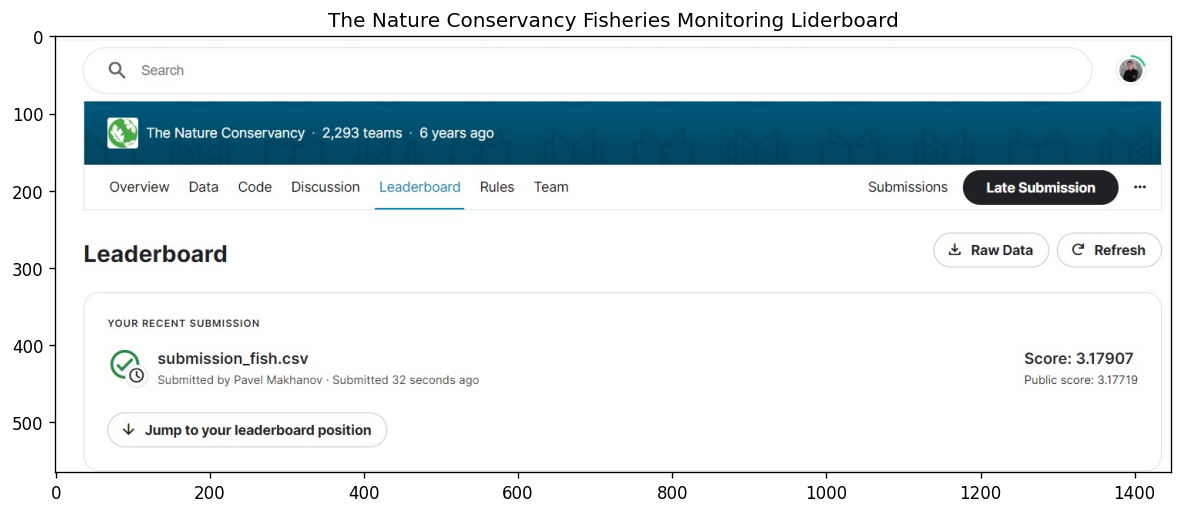

In [ ]:
fish_Submit = cv2.imread('sub_fish.jpg')
plt.figure(figsize= (12,12), dpi= 120)
plt.imshow(cv2.cvtColor(fish_Submit, cv2.COLOR_BGR2RGB))
plt.title('The Nature Conservancy Fisheries Monitoring Liderboard')
plt.show()